In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Dog_Cat/train.zip" -d "/content/drive/MyDrive/Colab Notebooks/Dog_Cat/"

In [ ]:
#!pip install tensorflow-addons
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 設定資料、顯示圖片

In [ ]:
import glob
base_path = "/content/drive/MyDrive/Colab Notebooks/Dog_Cat/"
train_path = f"{base_path}/train"
test_path = f"{base_path}/test"
dog_train_set = (glob.glob(f"{train_path}/dog.*.jpg"))
cat_train_set = (glob.glob(f"{train_path}/cat.*.jpg"))
print(f"{len(dog_train_set)}, {len(cat_train_set)}")

12500, 12500


In [ ]:
class_name = {0:"cat", 1:"dog"}
X_df = pd.DataFrame(columns=["path", "target"])
for path in dog_train_set:
    s = pd.Series([path, 1], index=["path", "target"])
    X_df = X_df.append(s, ignore_index=True)
for path in cat_train_set:
    s = pd.Series([path, 0], index=["path", "target"])
    X_df = X_df.append(s, ignore_index=True)
X_df

,path,target
0,/content/drive/MyDrive/Colab Notebooks/Dog_Cat...,1
1,/content/drive/MyDrive/Colab Notebooks/Dog_Cat...,1
2,/content/drive/MyDrive/Colab Notebooks/Dog_Cat...,1
3,/content/drive/MyDrive/Colab Notebooks/Dog_Cat...,1
4,/content/drive/MyDrive/Colab Notebooks/Dog_Cat...,1
...,...,...
24995,/content/drive/MyDrive/Colab Notebooks/Dog_Cat...,0
24996,/content/drive/MyDrive/Colab Notebooks/Dog_Cat...,0
24997,/content/drive/MyDrive/Colab Notebooks/Dog_Cat...,0
24998,/content/drive/MyDrive/Colab Notebooks/Dog_Cat...,0


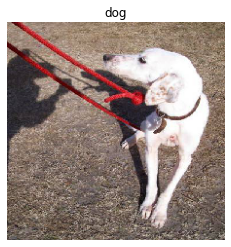

In [ ]:
from keras.preprocessing.image import load_img
import random
num = random.randint(0, len(X_df.index))
img = load_img(X_df["path"][num], target_size=(224,224))
plt.axis("off")
plt.title(class_name[X_df["target"][num]])
plt.imshow(img)

# 切分資料

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df["path"],
                              X_df["target"],
                              test_size=0.1,
                              random_state=1031)
X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((22500,), (2500,), 0    11287
 1    11213
 Name: target, dtype: int64, 1    1287
 0    1213
 Name: target, dtype: int64)

# 使用ImageDataGenerator準備資料的方法

In [ ]:
train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_test, y_test], axis=1)
train_df["target"] = [str(val) for val in train_df["target"]]
valid_df["target"] = [str(val) for val in valid_df["target"]]
train_df.shape, valid_df.shape

((22500, 2), (2500, 2))

In [ ]:
batch_size, target_size = 32, (224,224)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                            x_col="path",y_col="target",
                            target_size=target_size,
                            batch_size=batch_size,
                            class_mode='categorical')
valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,
                            x_col="path",y_col="target",
                            target_size=target_size,
                            batch_size=batch_size,
                            class_mode='categorical',shuffle=False)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


# 導入VGG16模型

In [ ]:
vgg = VGG16(include_top=False, input_shape=(224,224,3))
vgg.trainable = False
#vgg.summary(), vgg.layers

# 保留VGG16_Flatten前所有結構，自行修改輸出層，輸入前要加上校正層。

In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
for l in vgg.layers:
    l.trainable = False
x = BatchNormalization()(vgg.output)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=2048, activation="relu")(x) #前一層參數量7*7*512=25088，每一層降低1/10 = 25088/2508，找2508最接近的2平方倍數
x = Dense(units=256, activation="relu")(x)
x = Dense(units=2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.compile(optimizer=tfa.optimizers.RectifiedAdam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# 設定儲存最佳模型參數、提早停止模型訓練、儲存History

In [ ]:
import os
model_dir = base_path
file_name = "dog_cat_vgg16-best-model"
modelfile = f"{model_dir}/{file_name}.h5"
logfile = f"{model_dir}/{file_name}_training.log"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
model_chpo = keras.callbacks.ModelCheckpoint(modelfile, monitor='val_accuracy', save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
csv_logger = keras.callbacks.CSVLogger(logfile)
callbacks_list = [model_chpo, earlystop, csv_logger]

# 訓練模型

In [ ]:
epochs = 50
cnn.fit(train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    # class_weight=class_weights,
    batch_size=batch_size,
    callbacks=callbacks_list)

Epoch 1/50
704/704 [==============================] - 134s 189ms/step - loss: 0.1943 - accuracy: 0.9451 - val_loss: 0.0421 - val_accuracy: 0.9820
Epoch 2/50
704/704 [==============================] - 132s 187ms/step - loss: 0.0476 - accuracy: 0.9824 - val_loss: 0.0394 - val_accuracy: 0.9856
Epoch 3/50
704/704 [==============================] - 132s 187ms/step - loss: 0.0360 - accuracy: 0.9864 - val_loss: 0.0418 - val_accuracy: 0.9860
Epoch 4/50
704/704 [==============================] - 131s 186ms/step - loss: 0.0327 - accuracy: 0.9890 - val_loss: 0.0450 - val_accuracy: 0.9852
Epoch 5/50
704/704 [==============================] - 129s 184ms/step - loss: 0.0283 - accuracy: 0.9887 - val_loss: 0.0477 - val_accuracy: 0.9832
Epoch 00005: early stopping


# 繪製Training圖表

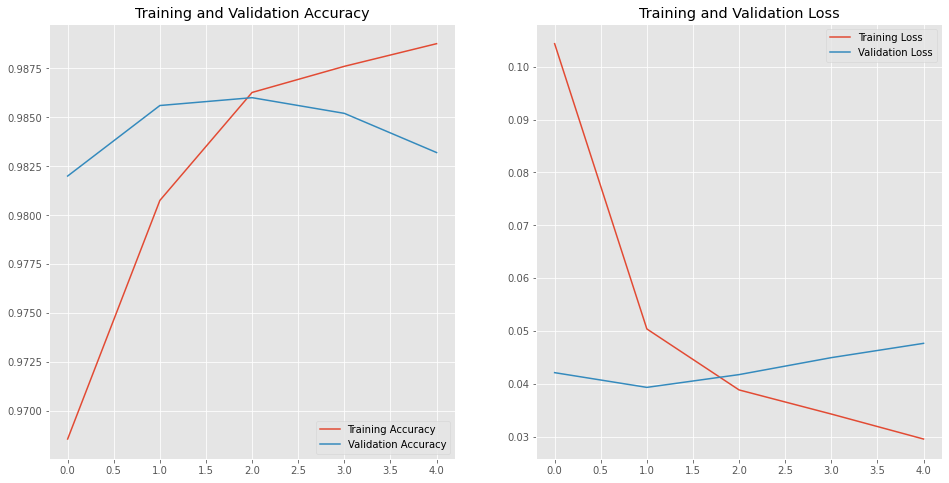

In [ ]:
model_dir = base_path
file_name = "dog_cat_vgg16-best-model"
logfile = f"{model_dir}/{file_name}_training.log"

def plot_accuracy_loss(file_name):
    import pandas as pd
    log_data = pd.read_csv(file_name)
    acc = log_data['accuracy']
    val_acc = log_data['val_accuracy']
    loss = log_data['loss']
    val_loss = log_data['val_loss']
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(log_data['epoch'], acc, label='Training Accuracy')
    plt.plot(log_data['epoch'], val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(log_data['epoch'], loss, label='Training Loss')
    plt.plot(log_data['epoch'], val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt.show()
plot_accuracy_loss(logfile)

# 模型預測
* 不重新訓練模型預測，請先執行一開始的import cell然後執行下方。
* 執行上述過程後，即可直接使用下方第二格進行預測分析。

In [ ]:
model = keras.models.load_model("dog_cat_vgg16-best-model.h5")

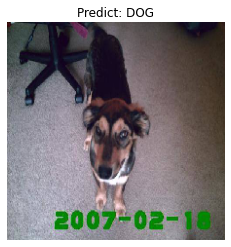

In [ ]:
import glob
from tensorflow.keras.preprocessing.image import load_img
import random

test_set = glob.glob("F:\\dog_cat_datasets\\test\\*.jpg")
num = random.randint(0, len(test_set))
class_name = {0:"CAT", 1:"DOG"}
img = load_img(test_set[num], target_size=(224,224))
pred_img = np.expand_dims(img, axis=0)
pred = class_name[model.predict(pred_img).argmax()]
plt.axis("off")
plt.title(f"Predict: {pred}")
plt.imshow(img)